In [1]:
import os
import time
import sys
sys.path.insert(0, './')

import numpy as np

import torch
from pytorch_msssim import ssim

import torch
from util.data_parser import parse_data
from util.model_utils import model_load
from util.model_utils import test_model
from util.utility import find_gpu, Logger, progress_bar
from util.attacks import fgsm_attack, pgd_attack, FW_nuclear_attack, FW_spectral_attack, FW_Linf_attack, FW_L2_attack, FW_L1_attack

import matplotlib.pyplot as plt
%matplotlib inline

# 设备选择
device = torch.device(f"cuda:{find_gpu()}" if torch.cuda.is_available() and find_gpu() is not None else "cpu")
print(f"Using {device}.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using cuda:9.


In [2]:
# 计算 MSE, PSNR 和 SSIM
def calculate_metrics(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    ssim_val = ssim(img1, img2, data_range=1.0, size_average=True)  # 使用 pytorch-msssim

    return mse.item(), psnr.item(), ssim_val.item()

In [3]:
dataset = 'imagenet100'
batch_size = 16
model_type = 'resnet50'
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 初始化日志和保存目录
save_folder = f'./attackresult/{dataset}/{model_type}/'
os.makedirs(save_folder, exist_ok=True)
log_path = os.path.join(save_folder, 'logger.log')
logger = Logger(log_path=log_path)

# 假设你的数据加载函数可以这样调用（确保使用与训练时相同的参数）
_, _, testloader, _ = parse_data(name=dataset, batch_size=batch_size, valid_ratio=None)

model = model_load(dataset=dataset, model_type=model_type, model_path='./checkpoint', normalize=None)
model = model.to(device)
model.eval()  # 设置为评估模式

# 测试函数
def test(model, device, test_loader, attack_type, epsilon, iters):
    correct = 0
    total = 0

    start_time = time.time()  # 攻击开始时间
    model.eval()
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= 1000: break
        images, labels = images.to(device), labels.to(device)
        
        
        # 应用攻击
        if attack_type == 'fgsm':
            perturbed_images = fgsm_attack(model, images, labels, epsilon)
        elif attack_type == 'pgd':
            perturbed_images = pgd_attack(model, images, labels, eps=epsilon, alpha=alpha, iters=iters)
        elif attack_type == 'linf':
            perturbed_images = FW_Linf_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'l1':
            perturbed_images = FW_L1_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'l2':
            perturbed_images = FW_L2_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'nuclear':
            perturbed_images = FW_nuclear_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
        elif attack_type == 'spectral':
            perturbed_images = FW_spectral_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            
        

        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        
        
        # mse, psnr, ssim_val = calculate_metrics(images, perturbed_images)
        # print(f'epsilons: {epsilon}, MSE: {mse}, PSNR: {psnr}, SSIM: {ssim_val}')
        

        ax1 = axes[0]
        ax2 = axes[1]
        img1 = images[0].detach().cpu().numpy()  # 反标准化
        label1 = labels[0]
        img2 = perturbed_images[0].detach().cpu().numpy()  # 反标准化
        label2 = predicted[0]
        

        
        ax1.imshow(np.transpose(img1, (1, 2, 0)))
        ax1.set_title(label1)
        
        ax2.imshow(np.transpose(img2, (1, 2, 0)))
        ax2.set_title(label2)
        plt.show()
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar(batch_idx, len(test_loader), f'| Acc: {100.*correct/total:.3f}% ({correct}/{total})')
    print(' ')
    
    
      

    end_time = time.time()  # 攻击结束时间
    attack_time = end_time - start_time  # 计算总耗时
    
    accuracy = 100 * correct / total
    logger.log(f'Accuracy of the model under {attack_type.upper()} attack: {accuracy:.2f}%')
    logger.log(f'Total time taken for {attack_type.upper()} attack: {attack_time:.2f} seconds')
    logger.log(f' ')

Data root in ./data/imagenet100
129395 instances are picked from the training set
ResNet: num_block_list = [3, 4, 6, 3], num_class = 100


clean
nuclear


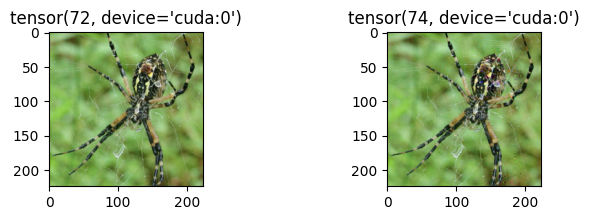

 [================================================================>]  Step: 2s213ms | Tot: 22m2s | | Acc: 0.840% (42/500 313/313 13 
 
spectral


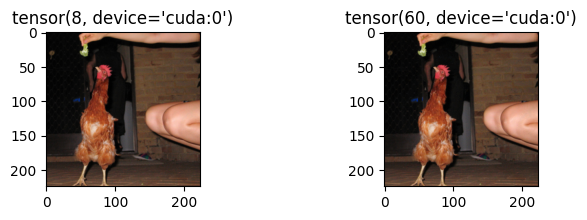

 [================================================================>]  Step: 2s187ms | Tot: 22m18s | | Acc: 0.080% (4/500 313/313 3 
 


In [4]:
# 定义攻击的参数
epsilon = 10
alpha = 1e-10  
iters = 10 # 
# 运行测试
print('clean')
criterion = torch.nn.CrossEntropyLoss()
# test_model(model, testloader, device, criterion)
# print('fgsm')
# test(model, device, testloader, 'fgsm', epsilon, iters)

# print('pgd')
# test(model, device, testloader, 'pgd', epsilon, iters)

# print('linf')
# test(model, device, testloader, 'linf', epsilon, iters)

# print('l1')
# test(model, device, testloader, 'l1', epsilon, iters)

# print('l2')
# test(model, device, testloader, 'l2', epsilon, iters)

print('nuclear')
test(model, device, testloader, 'nuclear', epsilon, iters)

print('spectral')
test(model, device, testloader, 'spectral', epsilon, iters)


In [5]:
def imshow(img_T, ax, title=None):
    """显示单个图像的函数，进行反标准化并调整维度以适配 matplotlib 显示"""
    img = img_T[0].numpy()  # 反标准化
    ax.imshow(np.transpose(img, (1, 2, 0)))
    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img = std * img + mean
    img = np.clip(img, 0, 1)  # 确保图像数据在[0, 1]范围内
    if title:
        ax.set_title(title)
    ax.axis('off')

epsilons: 0, MSE: 0.0, PSNR: inf, SSIM: 1.0
epsilons: 0.1, MSE: 1.216948675164531e-07, PSNR: 69.14727783203125, SSIM: 0.9999642372131348
epsilons: 1, MSE: 4.2046208363899495e-06, PSNR: 53.762733459472656, SSIM: 0.9986696243286133
epsilons: 3, MSE: 2.5786719561438076e-05, PSNR: 45.88603973388672, SSIM: 0.9924332499504089
epsilons: 20, MSE: 0.0009297236683778465, PSNR: 30.316463470458984, SSIM: 0.8782958388328552


/home/linfeng/anaconda3/envs/attack/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


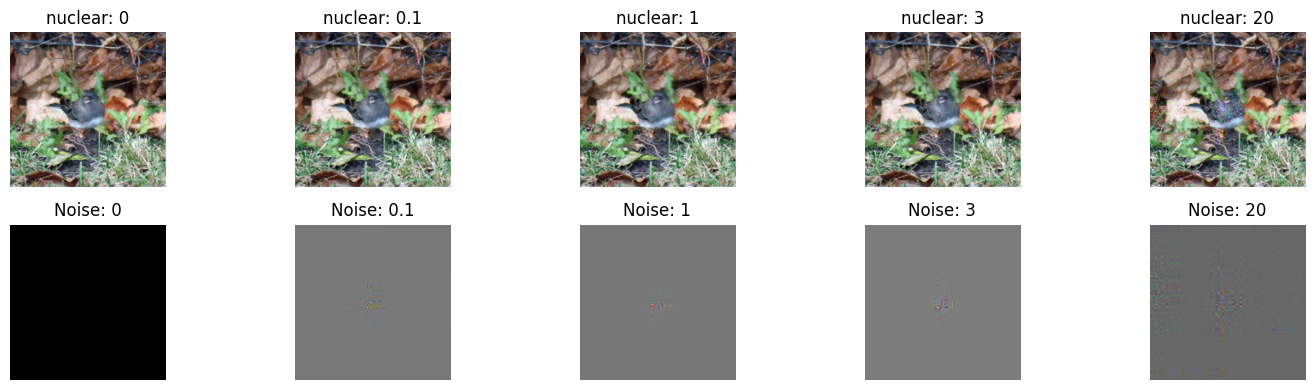

epsilons: 0, MSE: 0.0, PSNR: inf, SSIM: 1.0
epsilons: 0.1, MSE: 6.888362276413762e-12, PSNR: 111.61884307861328, SSIM: 0.9999997019767761
epsilons: 1, MSE: 6.832212018359485e-10, PSNR: 91.65438842773438, SSIM: 0.9999997615814209
epsilons: 3, MSE: 6.0548401847881905e-09, PSNR: 82.17897033691406, SSIM: 0.9999974370002747
epsilons: 20, MSE: 2.3914412849990185e-07, PSNR: 66.2134017944336, SSIM: 0.9998956322669983


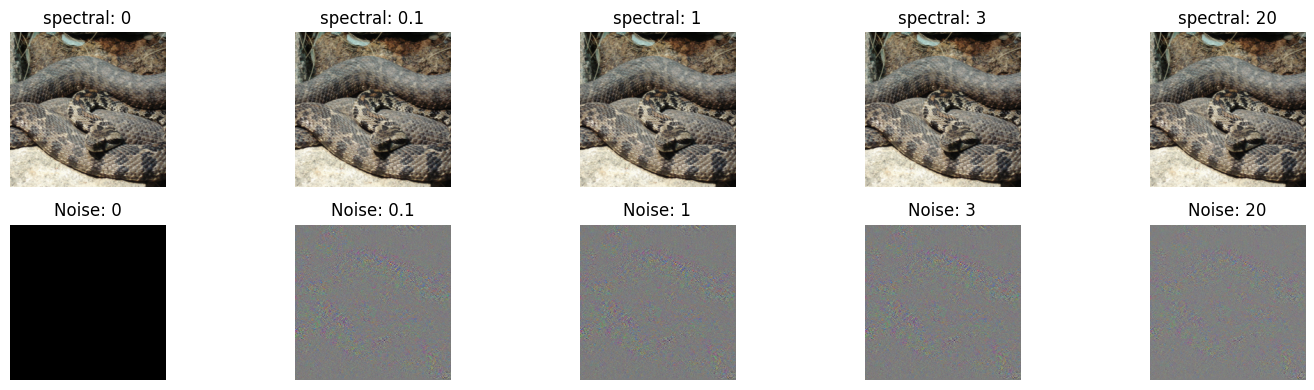

In [6]:
epsilons = [0,  0.1, 1, 3, 20]
# attack_types = ['fgsm', 'pgd', 'l2', 'linf', 'nuclear']
attack_types = ['nuclear', 'spectral']

for attack_type in attack_types:
    fig, axes = plt.subplots(2, len(epsilons), figsize=(15, 4))
    for i, (images, labels) in enumerate(testloader):
        if i >= 1: break
        images, labels = images.to(device), labels.to(device)
        original_data_np = images.detach().cpu()

        for j, epsilon in enumerate(epsilons):
            # 应用攻击
            if attack_type == 'fgsm':
                perturbed_images = fgsm_attack(model, images, labels, epsilon)
            elif attack_type == 'pgd':
                perturbed_images = pgd_attack(model, images, labels, eps=epsilon, alpha=alpha, iters=iters)
            if attack_type == 'linf':
                perturbed_images = FW_Linf_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'l1':
                perturbed_images = FW_L1_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'l2':
                perturbed_images = FW_L2_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'nuclear':
                perturbed_images = FW_nuclear_attack(model, images, labels, radius=epsilon, eps=1e-10, step_size=1.0, iters=iters, device=device)
            elif attack_type == 'spectral':
                perturbed_images = FW_spectral_attack(model, images, labels, radius=epsilon/16, eps=1e-10, step_size=1.0, iters=iters, device=device)
            
            perturbed_data_np = perturbed_images.detach().cpu()

            ax = axes[2*i, j]
            ax_perturbation = axes[i*2+1, j]
            imshow(perturbed_data_np, ax, f"{attack_type}: {epsilon}")
            
            noise = perturbed_data_np - original_data_np
            noise_normalized = (noise - noise.min()) / (noise.max() - noise.min())  # 归一化噪音到0-1
            white_background = torch.ones_like(images).cpu()  # 创建一个白色背景
            noise_on_white = white_background * noise_normalized  # 将噪音加到白色背景上
            imshow(noise_on_white, ax_perturbation, f"Noise: {epsilon}")
            
            mse, psnr, ssim_val = calculate_metrics(original_data_np, perturbed_data_np)
            print(f'epsilons: {epsilon}, MSE: {mse}, PSNR: {psnr}, SSIM: {ssim_val}')

    plt.tight_layout()
    plt.show()